In [13]:
# Load the dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r"D:/LSE Career Accelerator/Employer project/Adrian's financial metrics data/merged_event_panel_sub.csv")

In [14]:
# Sort properly
df = df.sort_values(["event_id", "event_day"])

In [5]:
# Compute CAR for each event window
df["CAR"] = df.groupby("event_id")["abnormal_return"].cumsum()

In [6]:
# Compute drift window for 0-5
car_0_5 = (
    df[(df["event_day"] >= 0) & (df["event_day"] <= 5)]
    .groupby("event_id")["abnormal_return"]
    .sum()
    .reset_index()
    .rename(columns={"abnormal_return": "CAR_0_5"})
)

car_5_20 = (
    df[(df["event_day"] > 5) & (df["event_day"] <= 20)]
    .groupby("event_id")["abnormal_return"]
    .sum()
    .reset_index()
    .rename(columns={"abnormal_return": "CAR_5_20"})
)

In [7]:
# Build an event‑level panel with regimes
event_panel = df.drop_duplicates("event_id")[[
    "event_id", "ticker", "reportedDate",
    "eps_surprise_regime", "profitability_regime", "margin_trend_regime"
]]

In [8]:
# Merge the two drift windows
event_panel = (
    event_panel
    .merge(car_0_5, on="event_id", how="left")
    .merge(car_5_20, on="event_id", how="left")
)

In [9]:
event_panel.head()

,event_id,ticker,reportedDate,eps_surprise_regime,profitability_regime,margin_trend_regime,CAR_0_5,CAR_5_20
0,AAPL_2022-01-27,AAPL,2022-01-27,large_positive,high,expansion,0.028679,-0.012228
1,AAPL_2022-04-28,AAPL,2022-04-28,moderate_positive,high,contraction,0.004684,-0.064212
2,AAPL_2022-07-28,AAPL,2022-07-28,moderate_positive,high,contraction,-0.002751,0.045774
3,AAPL_2022-10-27,AAPL,2022-10-27,small,high,stable,0.015074,-0.046872
4,AAPL_2023-02-02,AAPL,2023-02-02,moderate_negative,high,expansion,0.035928,0.024420


In [15]:
def plot_drift_for_company(df, ticker, regime_col):
    df_t = df[df["ticker"] == ticker].copy()
    
    # Melt for plotting
    df_melt = df_t.melt(
        id_vars=[regime_col],
        value_vars=["CAR_0_5", "CAR_5_20"],
        var_name="window",
        value_name="CAR"
    )
    
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=df_melt,
        x=regime_col,
        y="CAR",
        hue="window",
        palette="Set2"
    )
    
    plt.title(f"{ticker}: Drift Comparison by {regime_col.replace('_', ' ').title()}")
    plt.xlabel(regime_col.replace("_", " ").title())
    plt.ylabel("Average CAR")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()

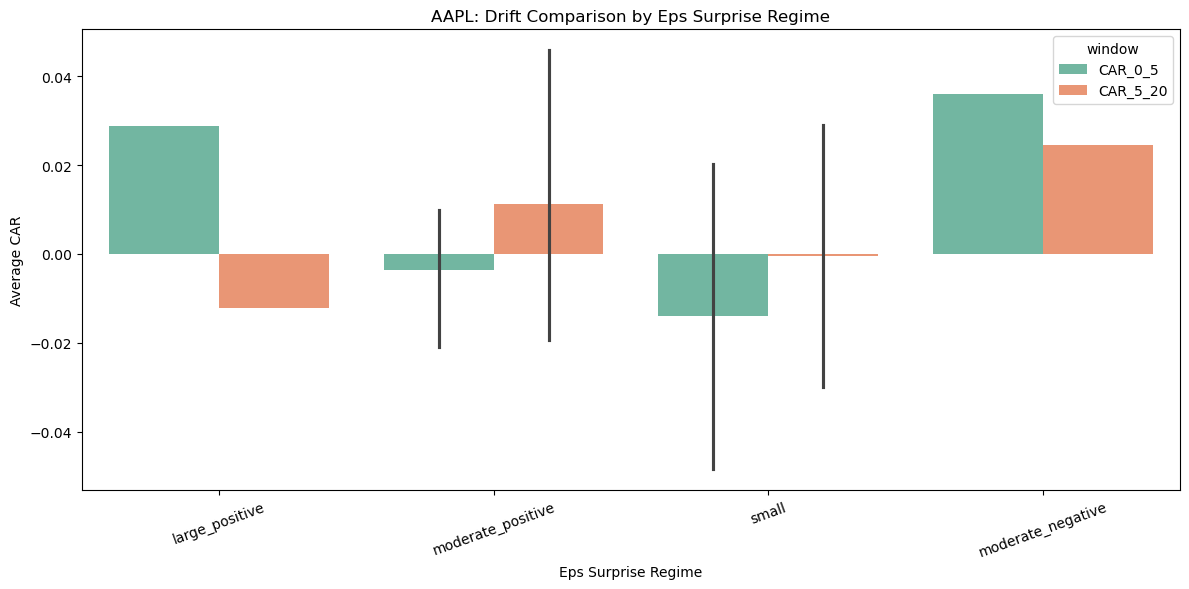

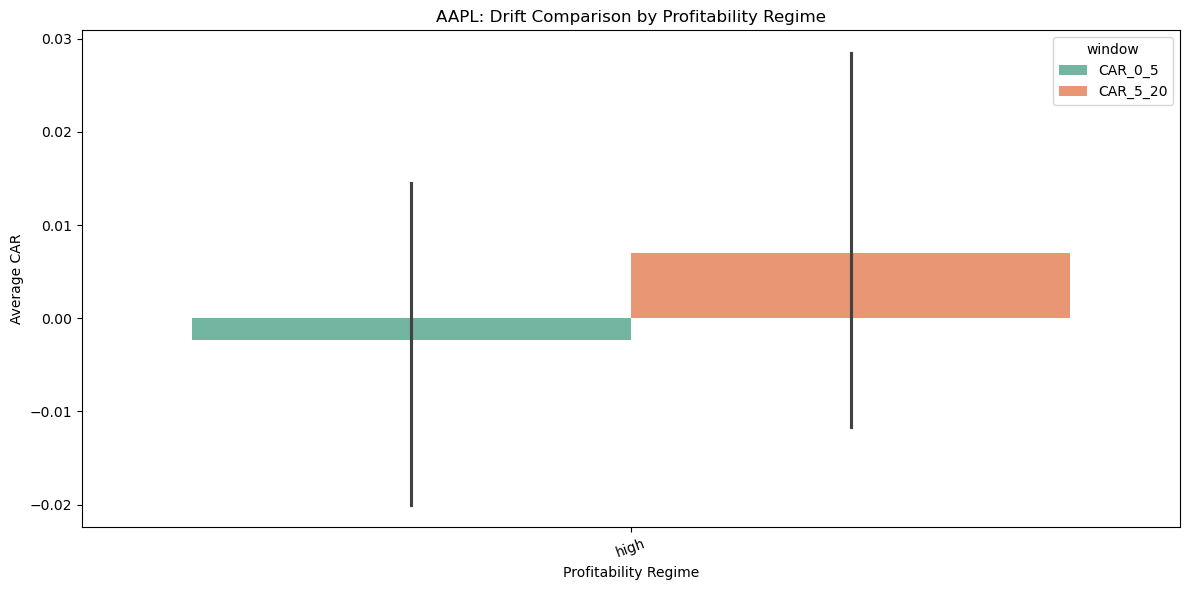

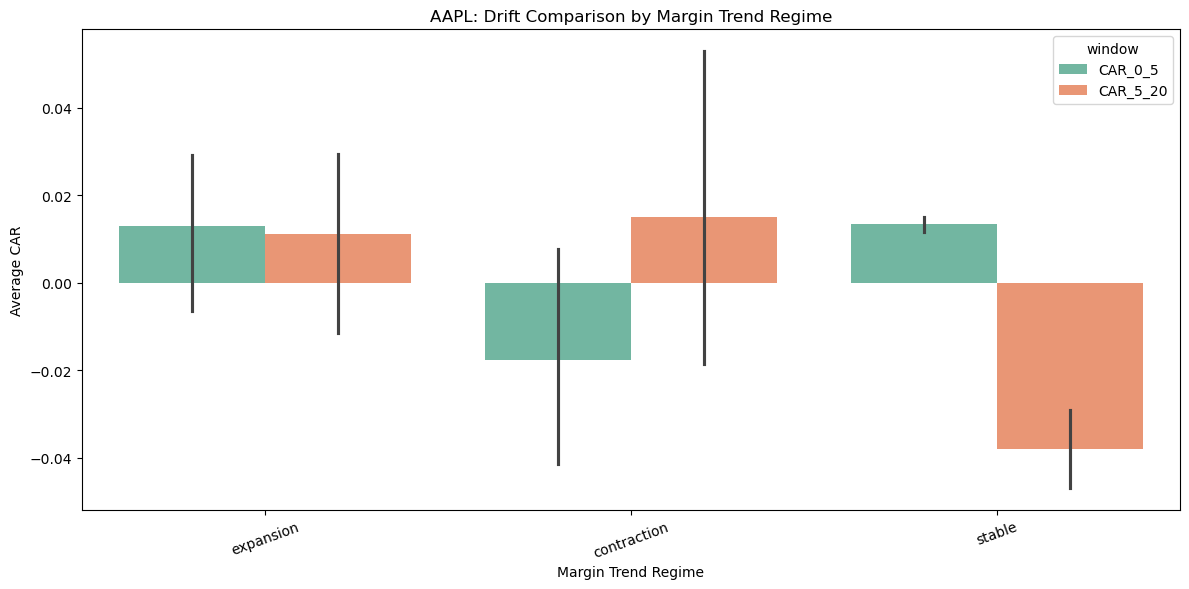

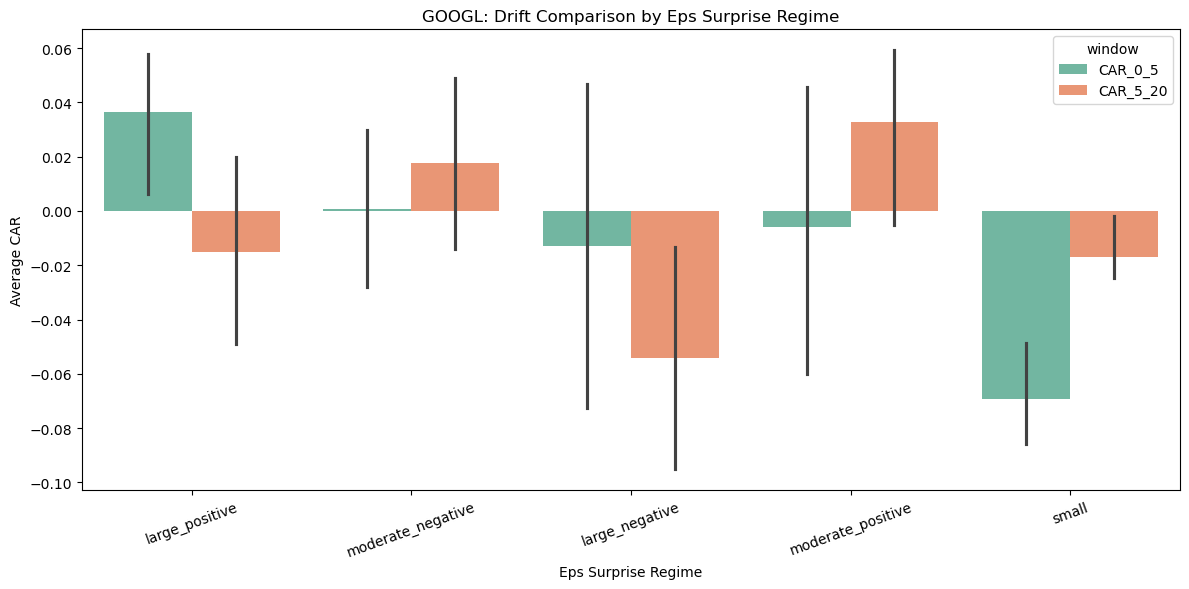

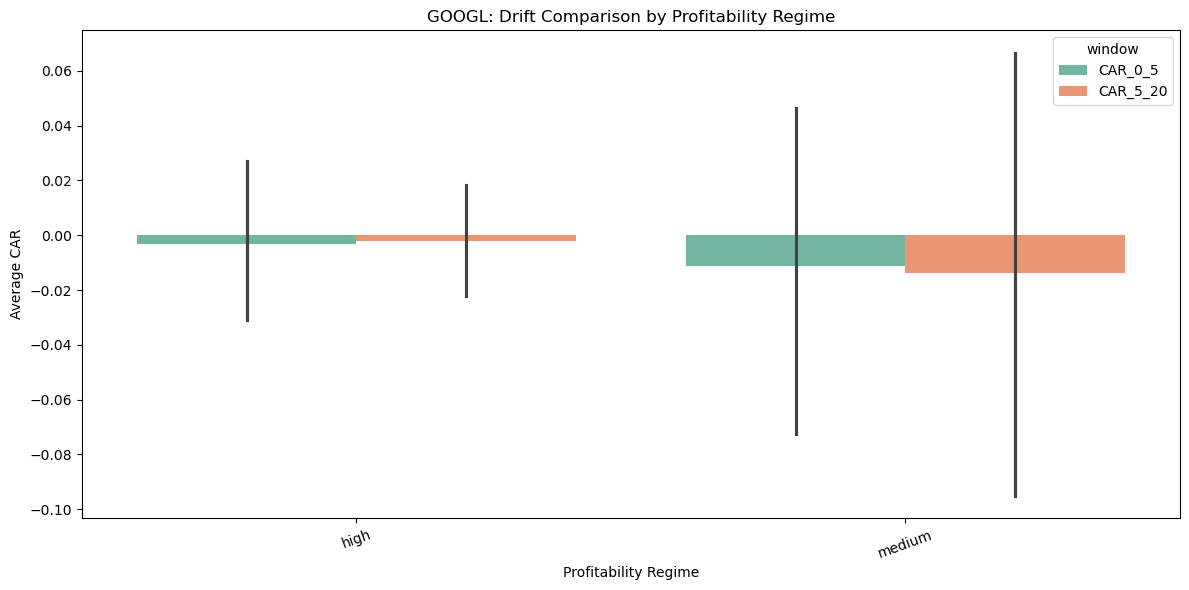

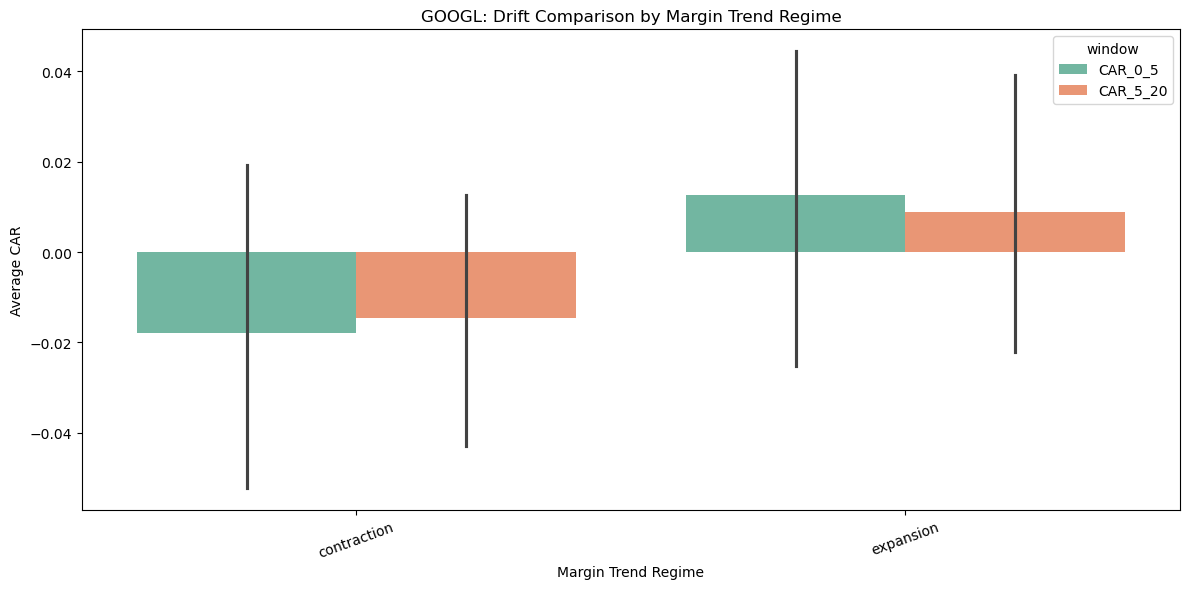

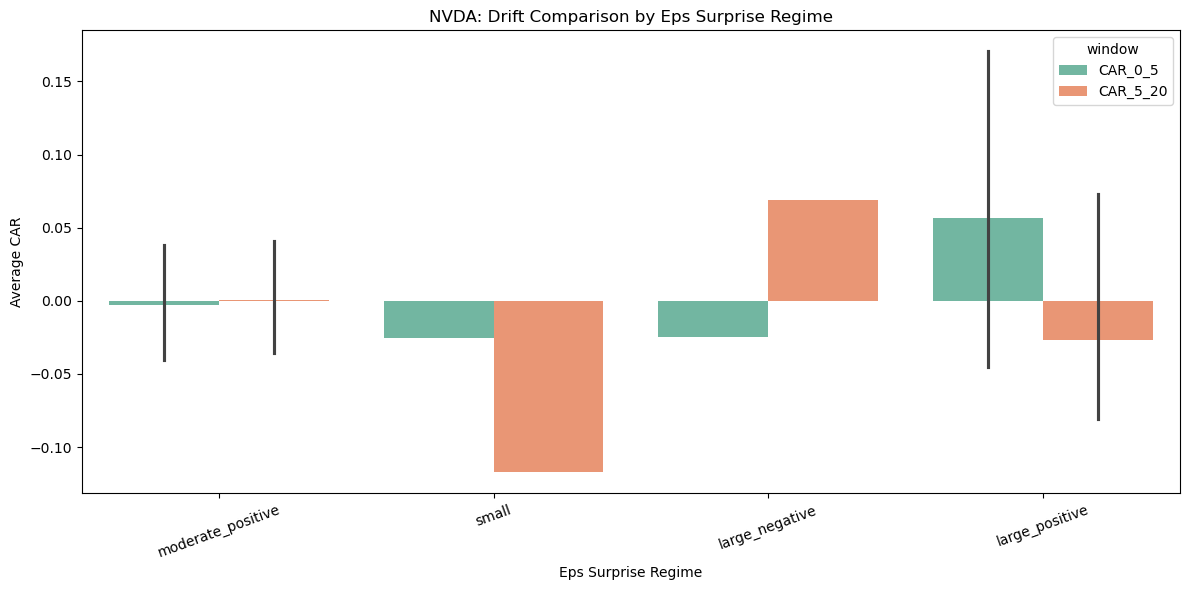

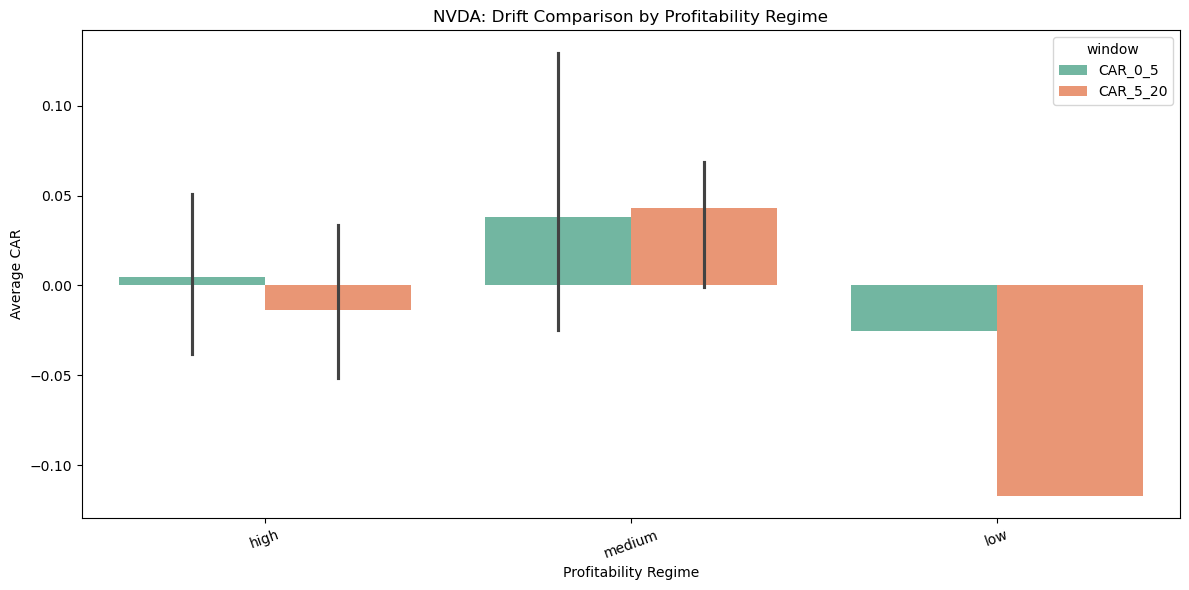

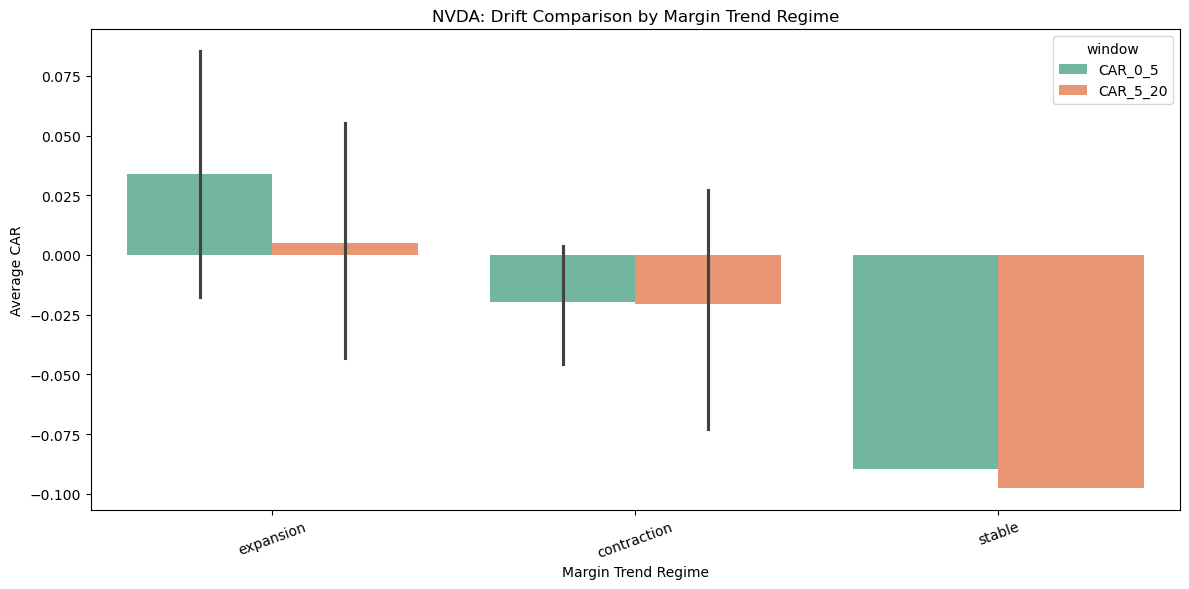

In [16]:
tickers = ["AAPL", "GOOGL", "NVDA"]
regimes = ["eps_surprise_regime", "profitability_regime", "margin_trend_regime"]

for t in tickers:
    for r in regimes:
        plot_drift_for_company(event_panel, t, r)

In [17]:
# Prepare line graph
def plot_line_for_company(df, ticker, regime_col):
    df_t = df[df["ticker"] == ticker].copy()
    
    # Aggregate mean CAR for each regime category
    df_grouped = df_t.groupby(regime_col)[["CAR_0_5", "CAR_5_20"]].mean().reset_index()
    
    # Melt for line plotting
    df_melt = df_grouped.melt(
        id_vars=[regime_col],
        value_vars=["CAR_0_5", "CAR_5_20"],
        var_name="window",
        value_name="CAR"
    )
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df_melt,
        x=regime_col,
        y="CAR",
        hue="window",
        marker="o",
        linewidth=2.5
    )
    
    plt.title(f"{ticker}: Drift Comparison by {regime_col.replace('_', ' ').title()}")
    plt.xlabel(regime_col.replace("_", " ").title())
    plt.ylabel("Average CAR")
    plt.xticks(rotation=20)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

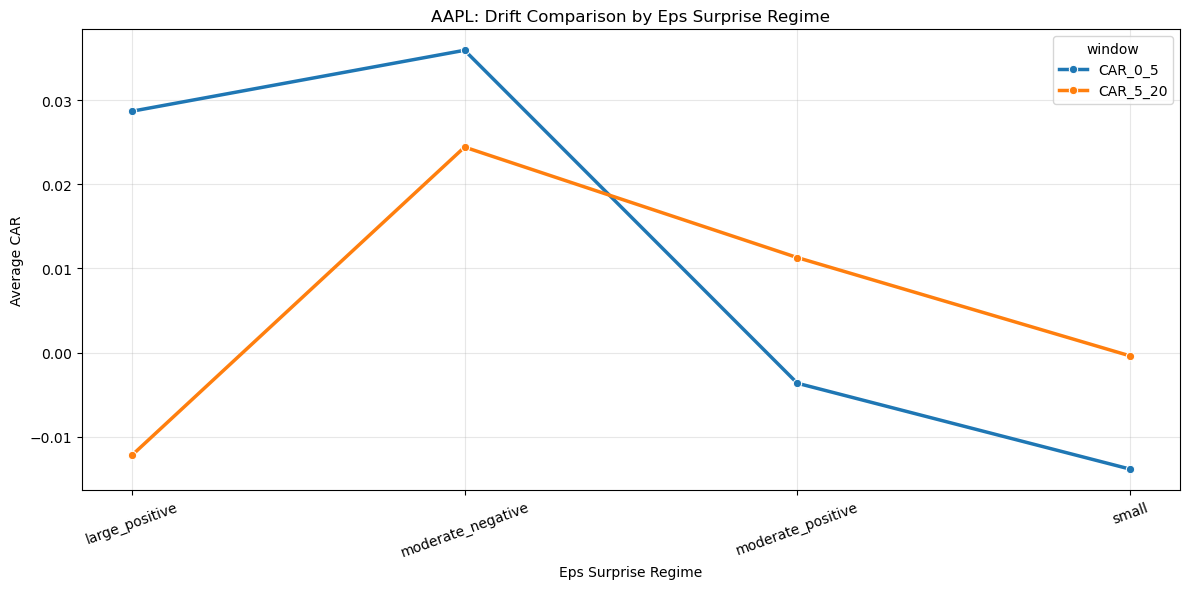

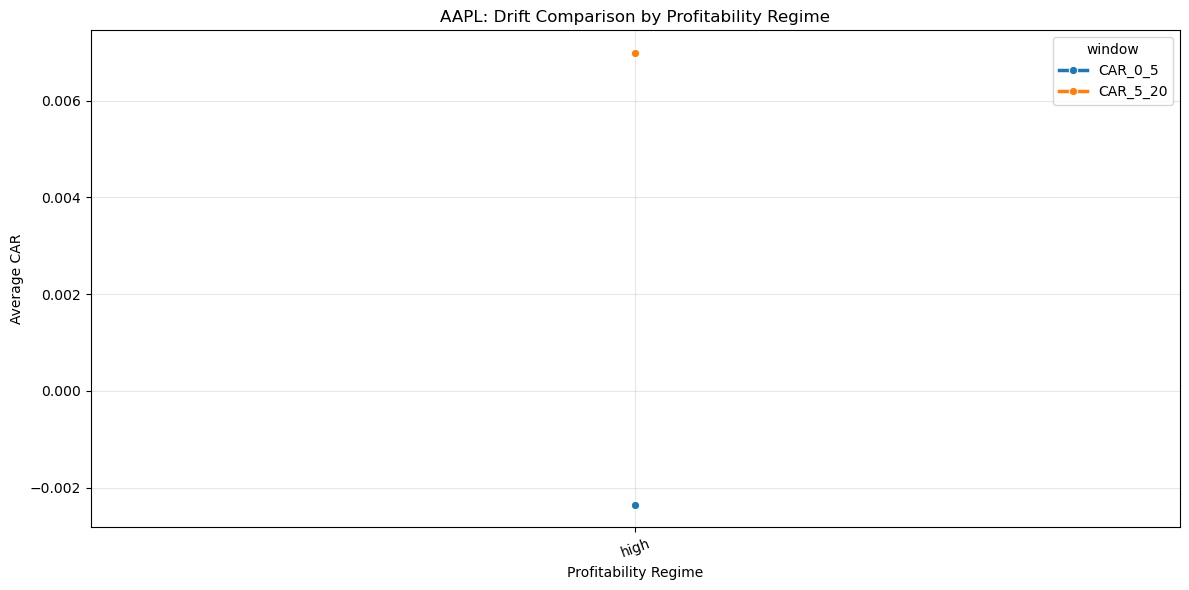

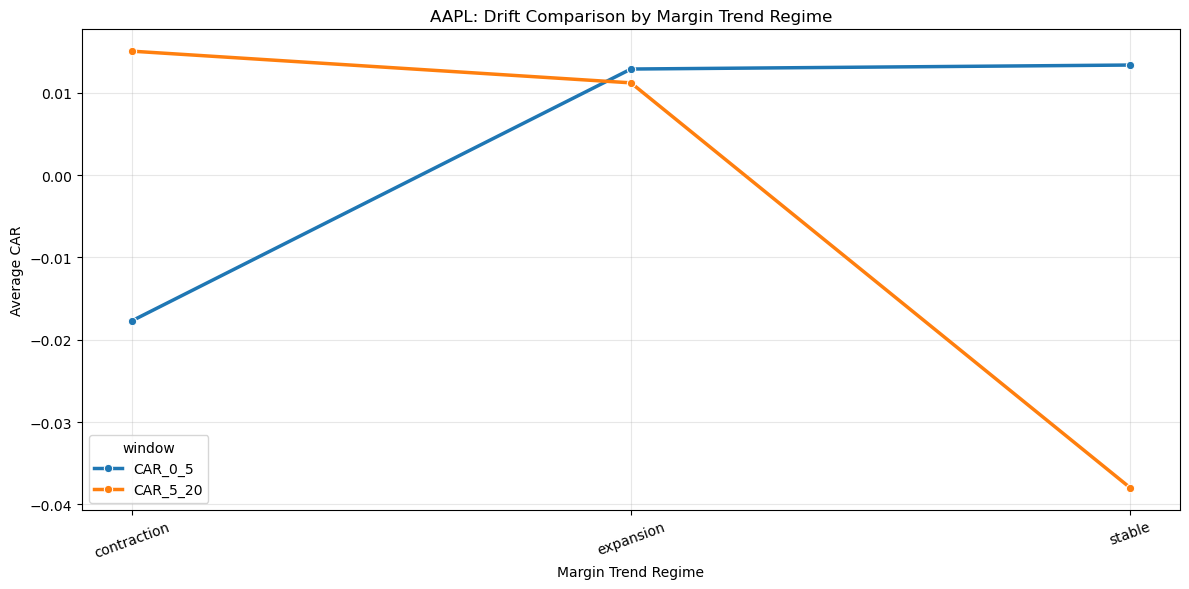

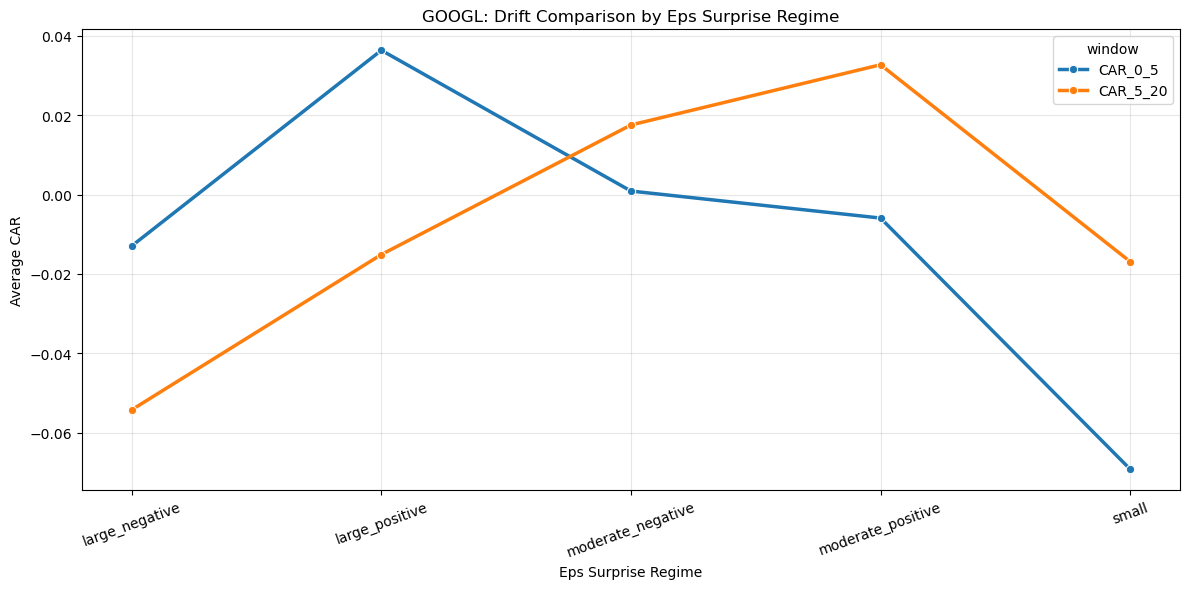

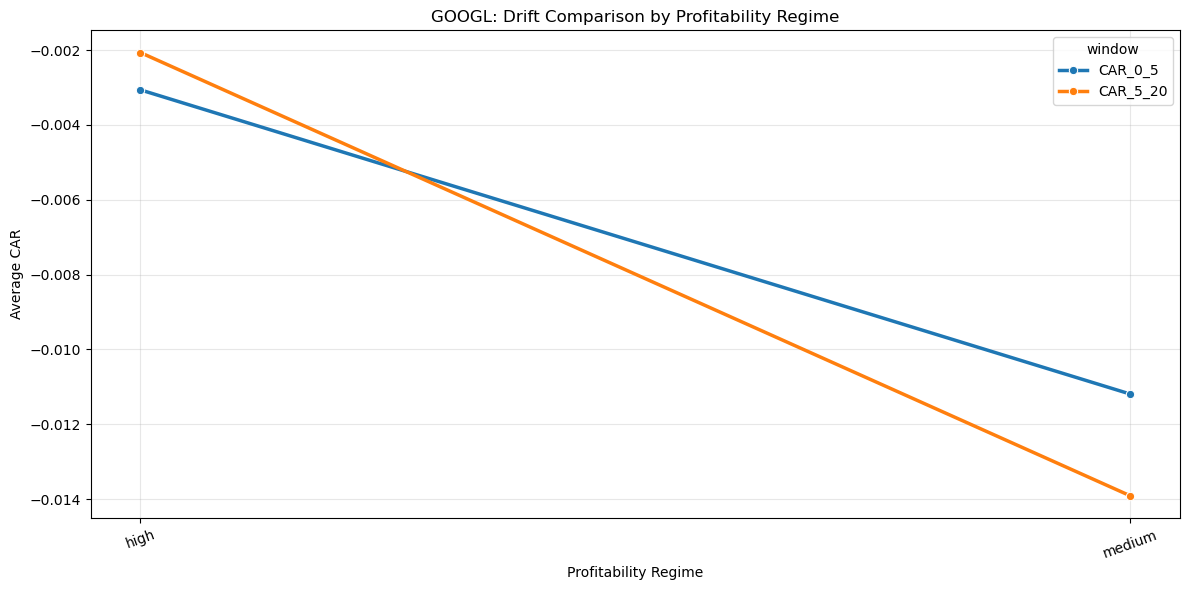

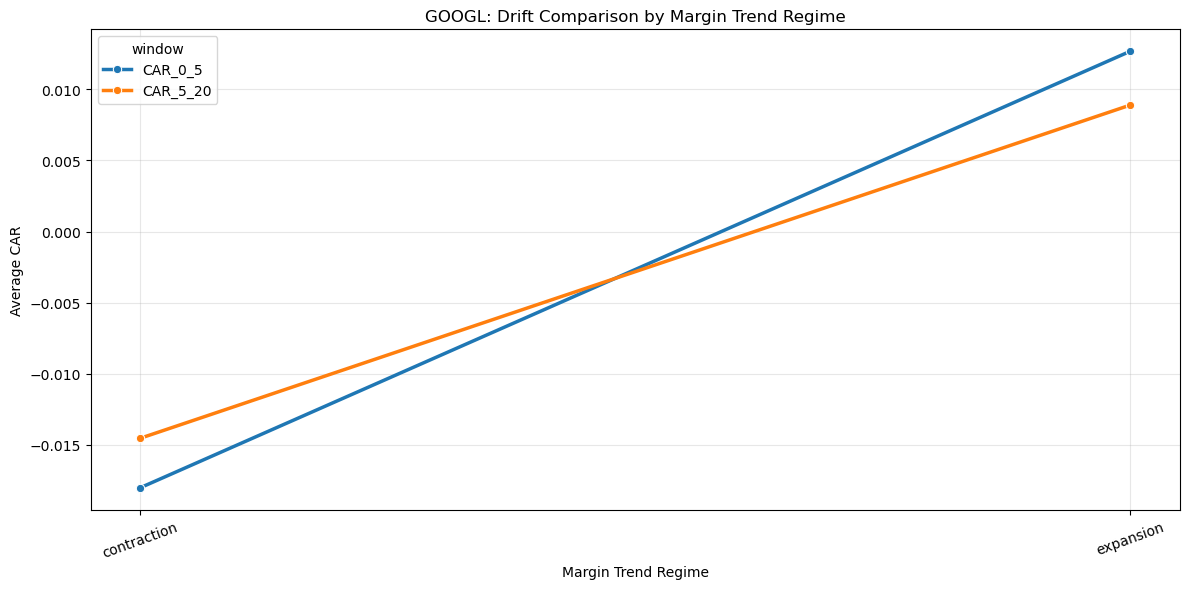

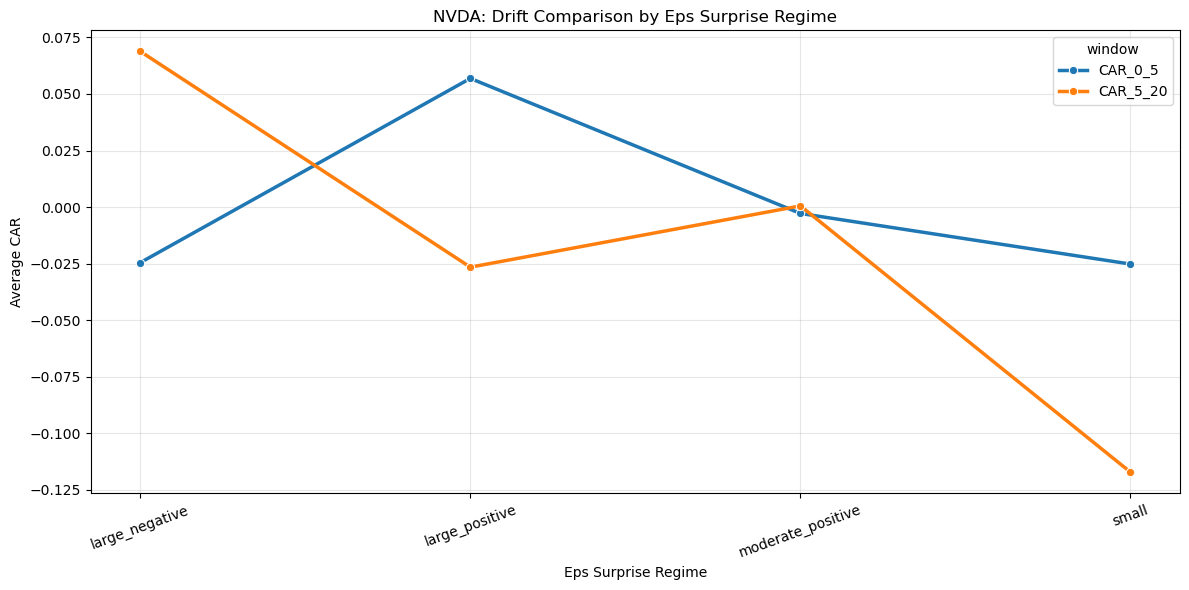

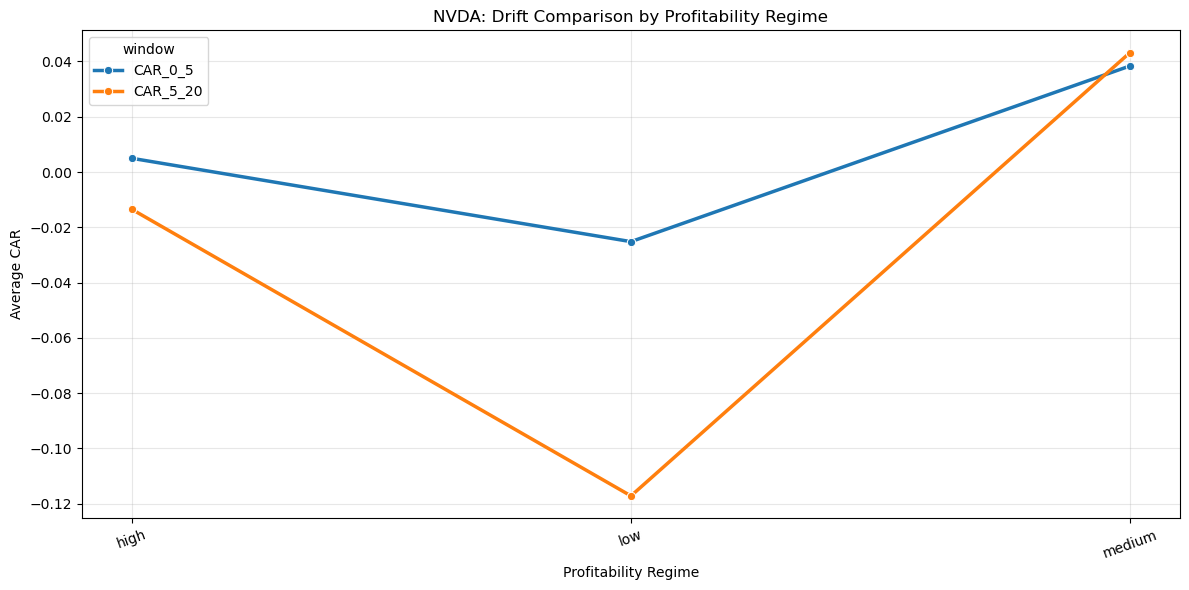

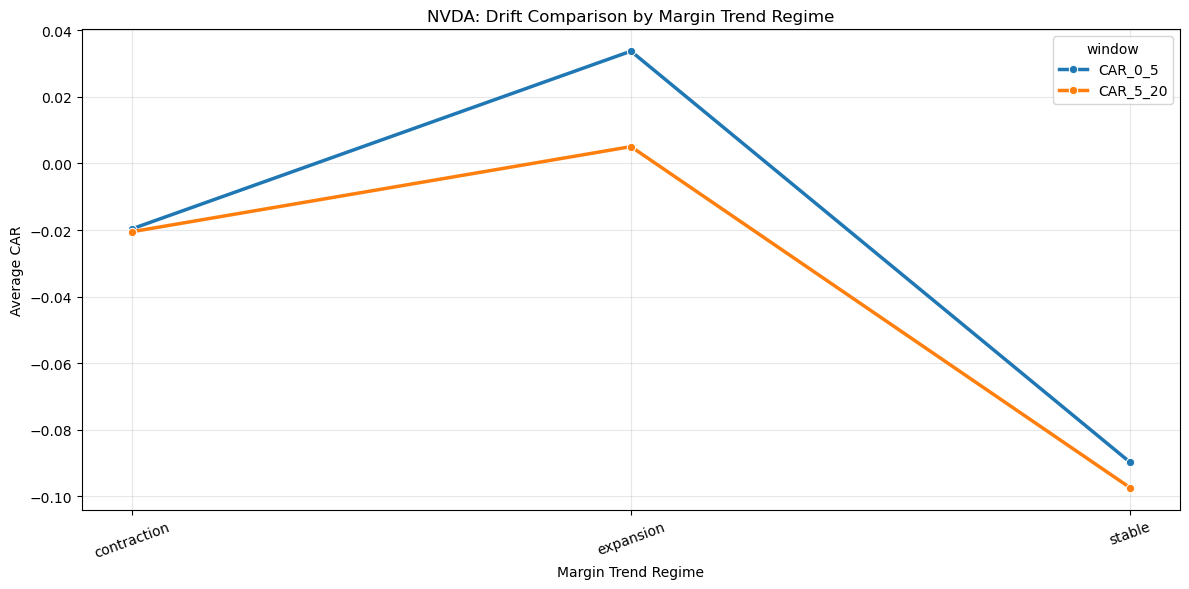

In [18]:
tickers = ["AAPL", "GOOGL", "NVDA"]
regimes = ["eps_surprise_regime", "profitability_regime", "margin_trend_regime"]

for t in tickers:
    for r in regimes:
        plot_line_for_company(event_panel, t, r)

In [19]:
# Filter data from 2022-2025
df["reportedDate"] = pd.to_datetime(df["reportedDate"])
df = df[(df["reportedDate"].dt.year >= 2022) & (df["reportedDate"].dt.year <= 2025)]

In [20]:
# Compute CAR path
df["CAR"] = df.groupby("event_id")["abnormal_return"].cumsum()

In [21]:
# Keep only event window 0-20
df_0_20 = df[(df["event_day"] >= 0) & (df["event_day"] <= 20)].copy()

In [24]:
def plot_avg_car_paths(df, ticker, regime_col):
    df_t = df[df["ticker"] == ticker].copy()
    
    # Compute average CAR per event_day per regime category
    df_avg = (
        df_t.groupby([regime_col, "event_day"])["CAR"]
        .mean()
        .reset_index()
    )
    
    plt.figure(figsize=(12, 6))
    
    sns.lineplot(
        data=df_avg,
        x="event_day",
        y="CAR",
        hue=regime_col,
        linewidth=2.5,
        marker="o"
    )
    
    plt.title(f"CAR Paths by {regime_col.replace('_', ' ').title()} — {ticker} (2022–2025)")
    plt.xlabel("Event Day (0–20)")
    plt.ylabel("Average CAR")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

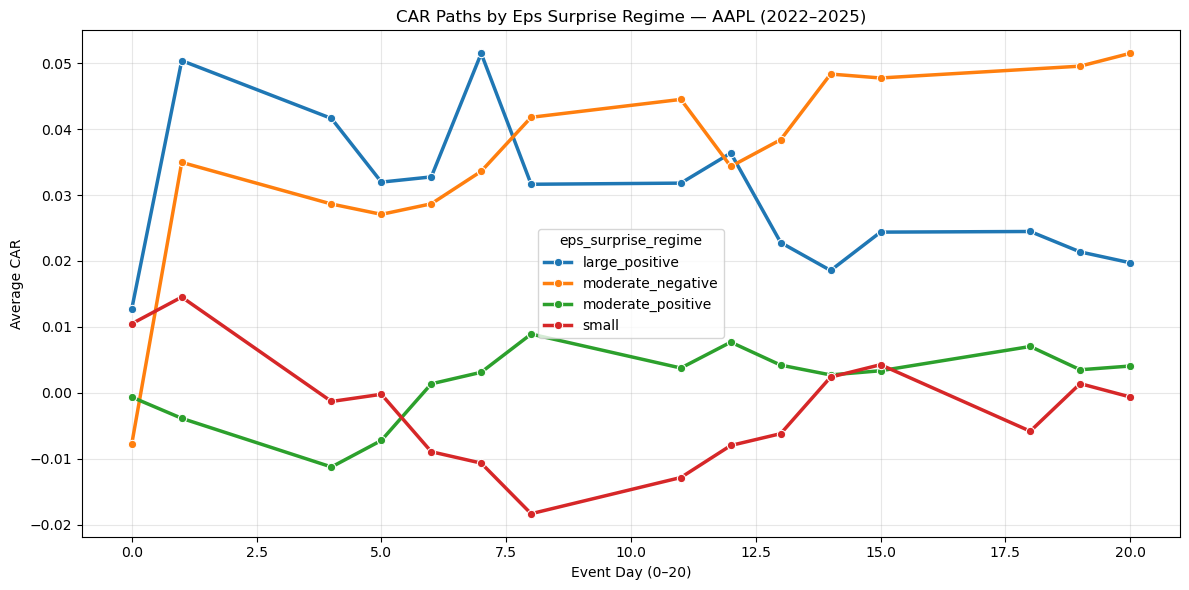

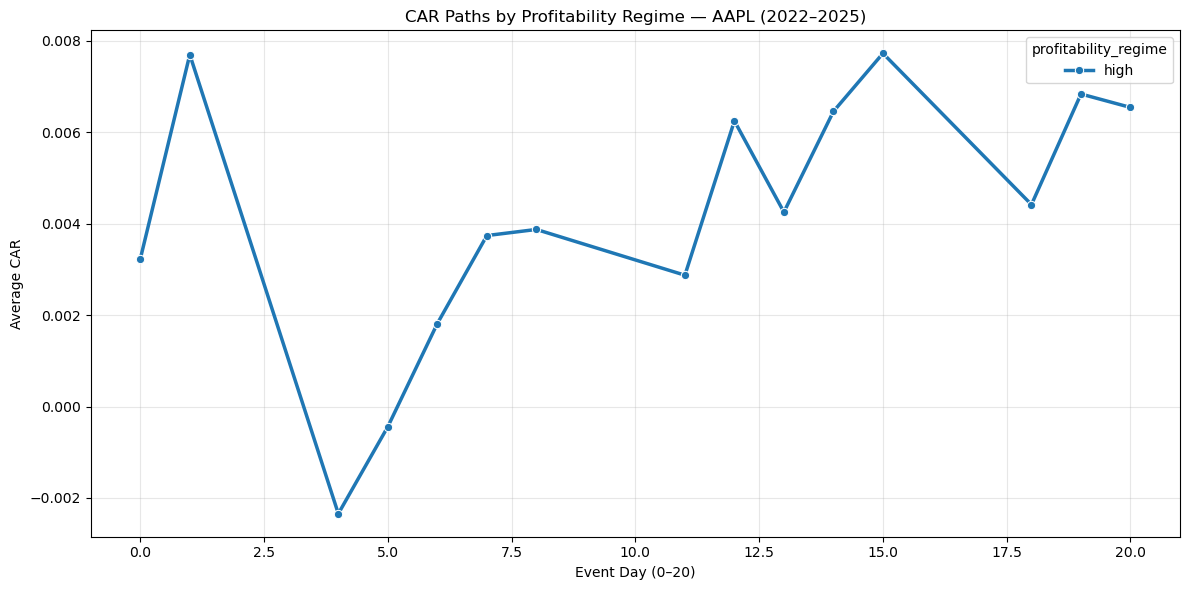

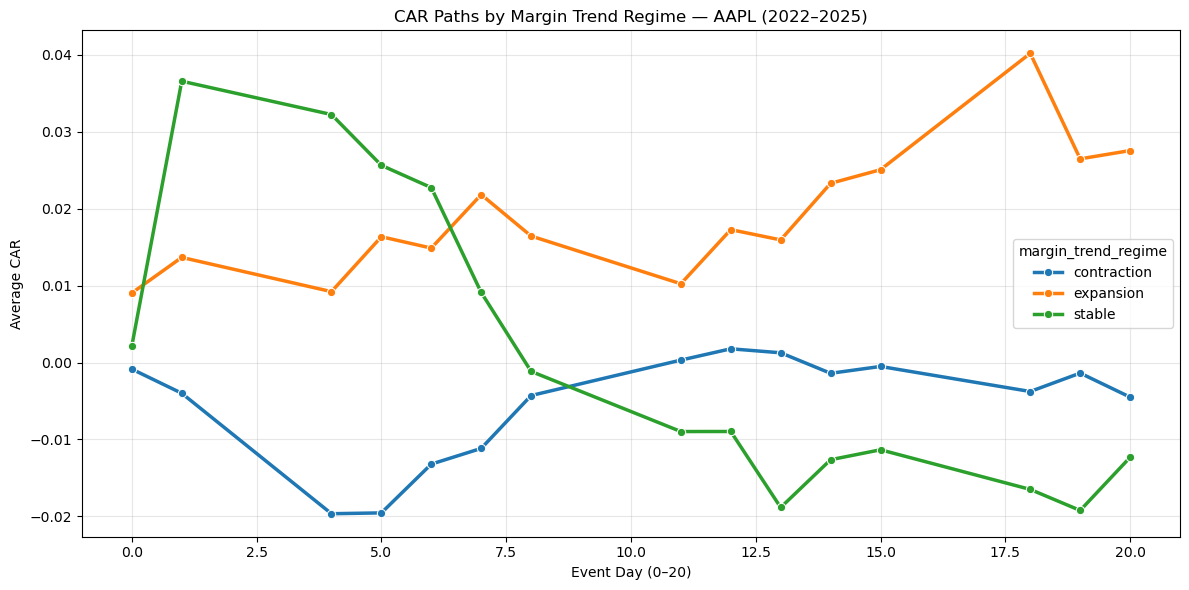

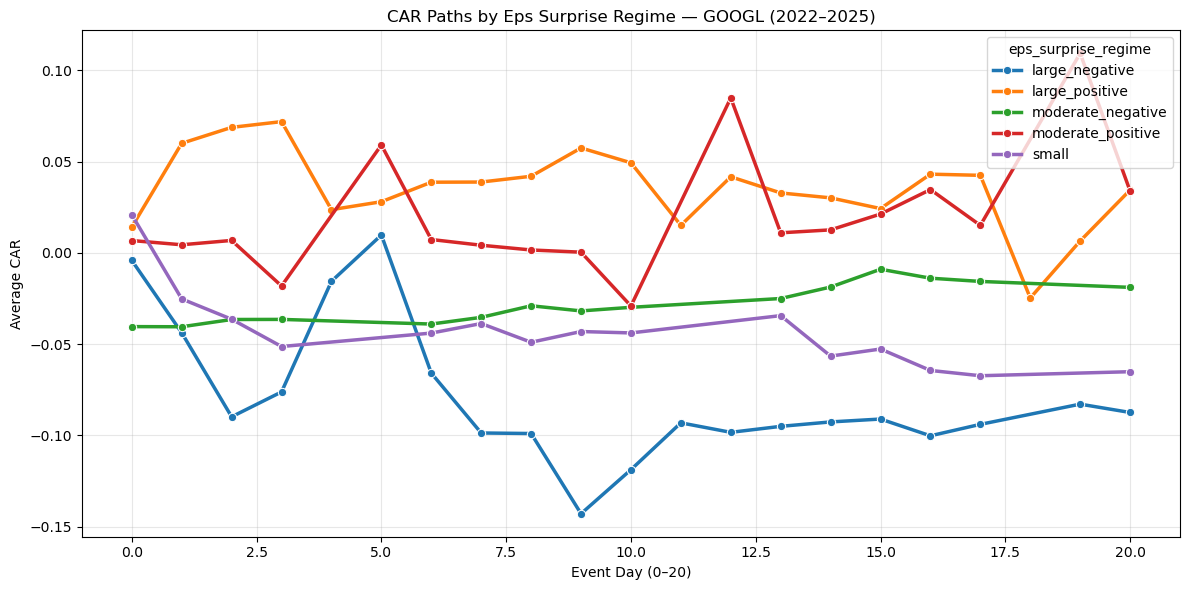

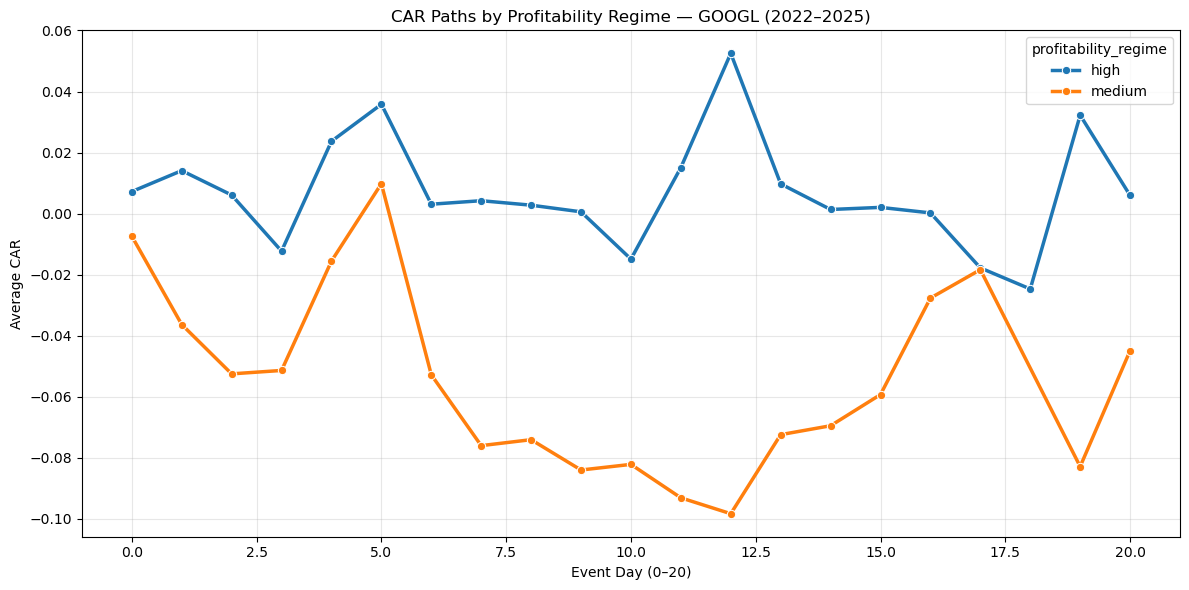

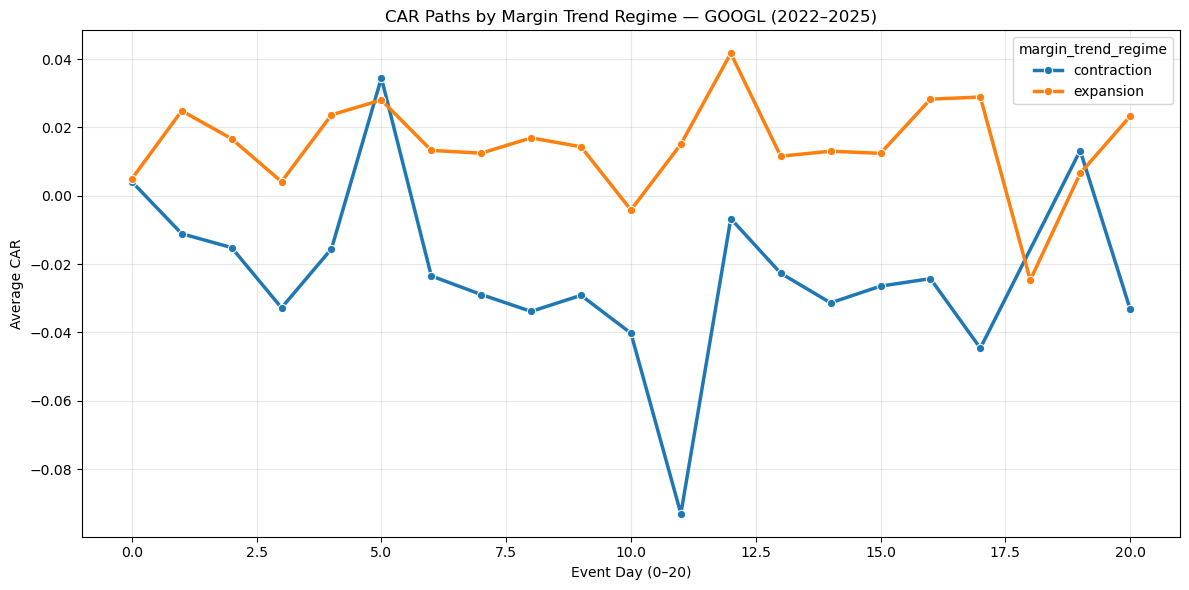

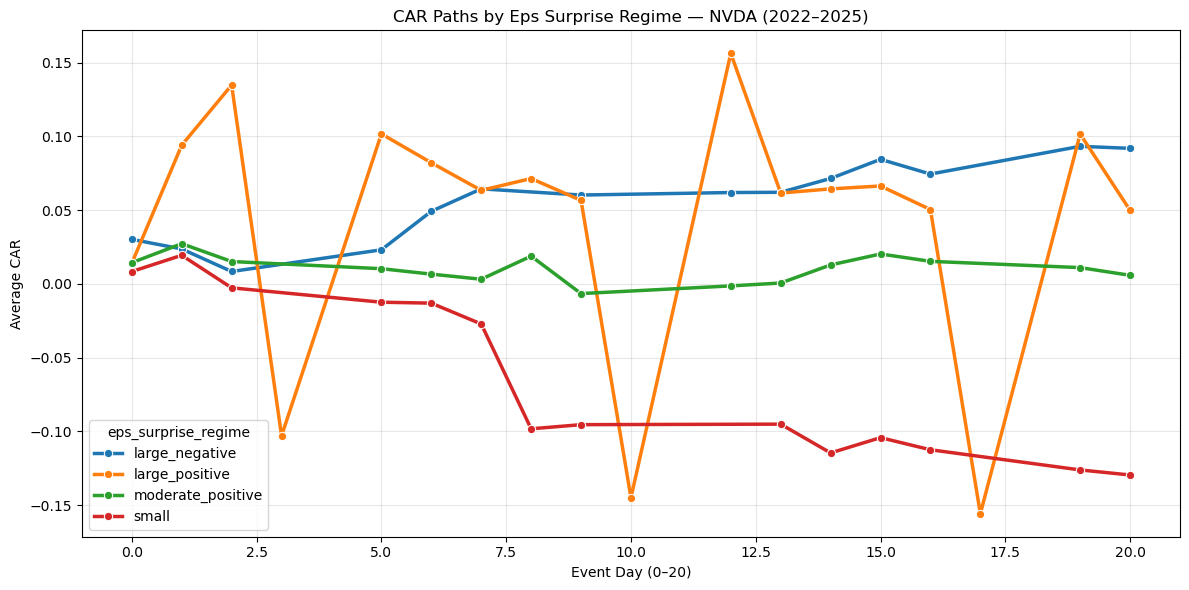

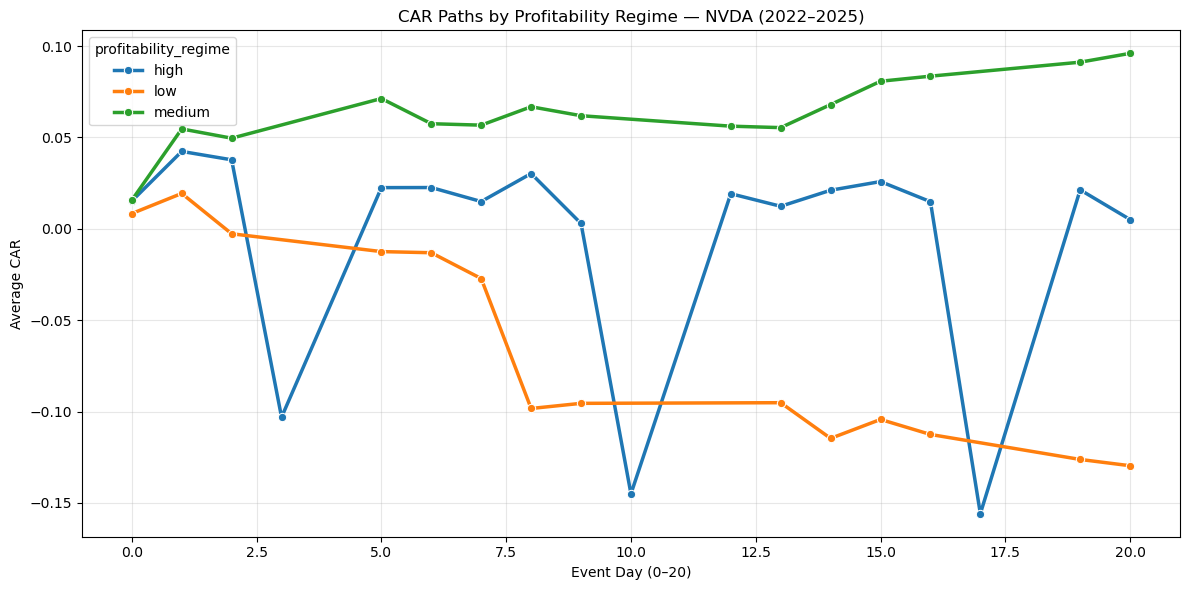

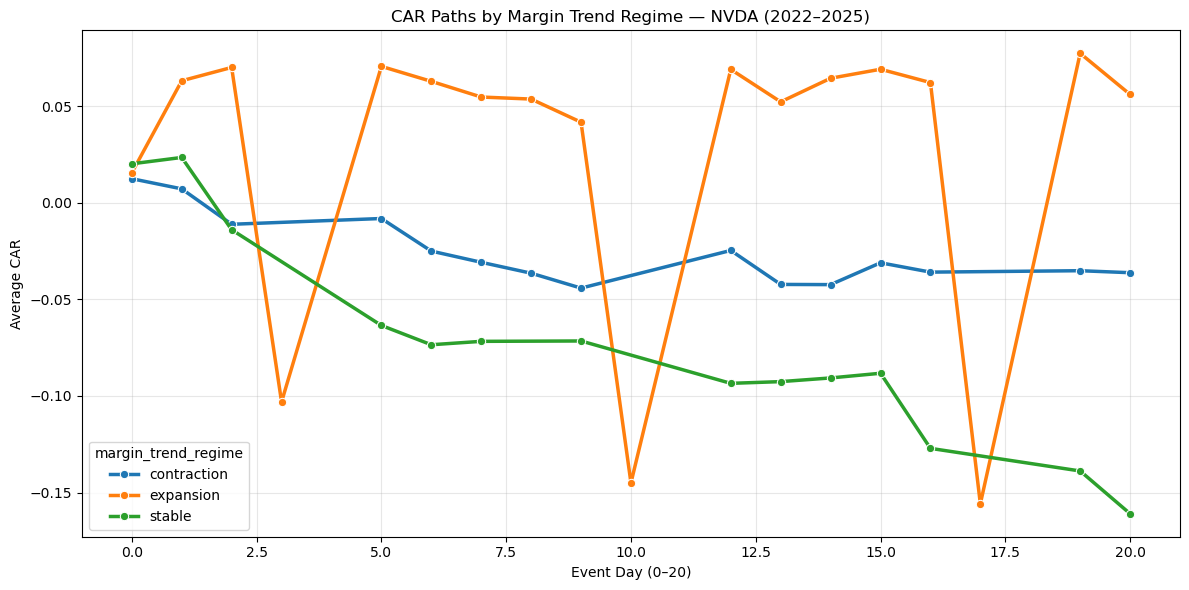

In [25]:
tickers = ["AAPL", "GOOGL", "NVDA"]
regimes = ["eps_surprise_regime", "profitability_regime", "margin_trend_regime"]

for t in tickers:
    for r in regimes:
        plot_avg_car_paths(df_0_20, t, r)

In [26]:
def plot_bar_for_company(df, ticker, regime_col):
    df_t = df[df["ticker"] == ticker].copy()
    
    # Aggregate mean CAR for each regime category
    df_grouped = (
        df_t.groupby(regime_col)[["CAR_0_5", "CAR_5_20"]]
        .mean()
        .reset_index()
    )
    
    # Melt for bar plotting
    df_melt = df_grouped.melt(
        id_vars=[regime_col],
        value_vars=["CAR_0_5", "CAR_5_20"],
        var_name="window",
        value_name="CAR"
    )
    
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=df_melt,
        x=regime_col,
        y="CAR",
        hue="window",
        palette="Set2"
    )
    
    plt.title(f"{ticker}: CAR_0_5 vs CAR_5_20 by {regime_col.replace('_', ' ').title()} (2022–2025)")
    plt.xlabel(regime_col.replace("_", " ").title())
    plt.ylabel("Average CAR")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()

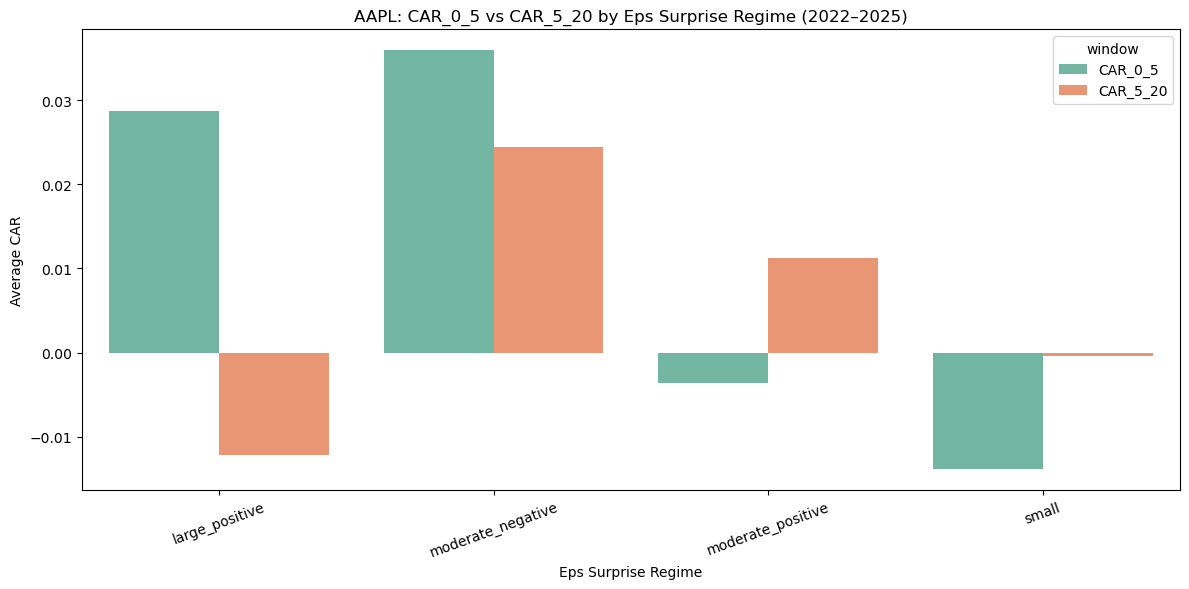

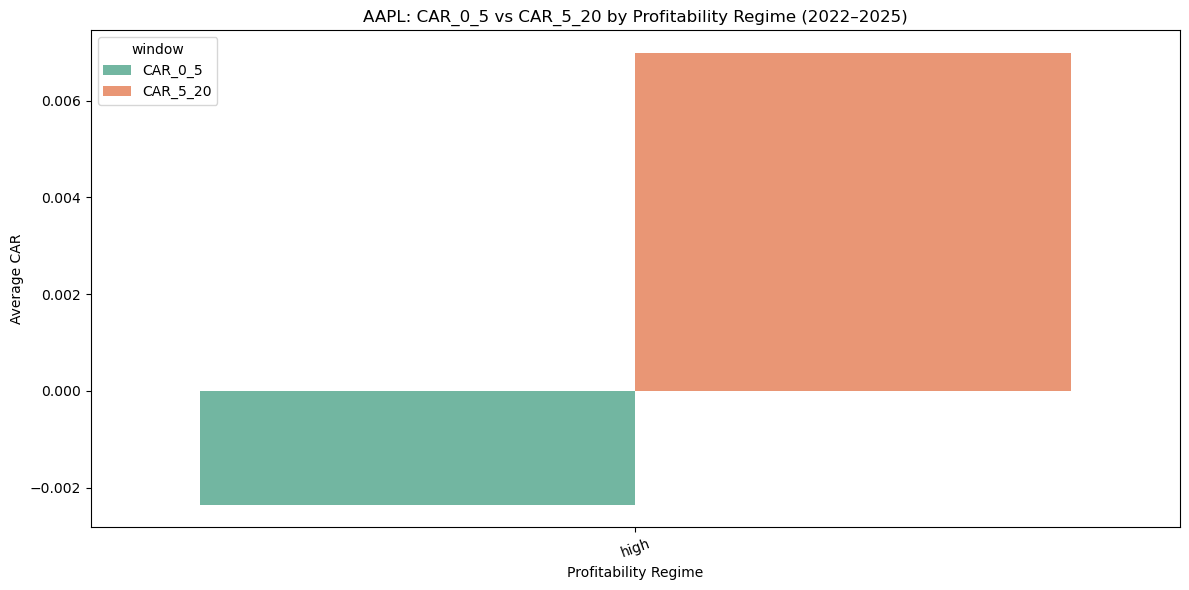

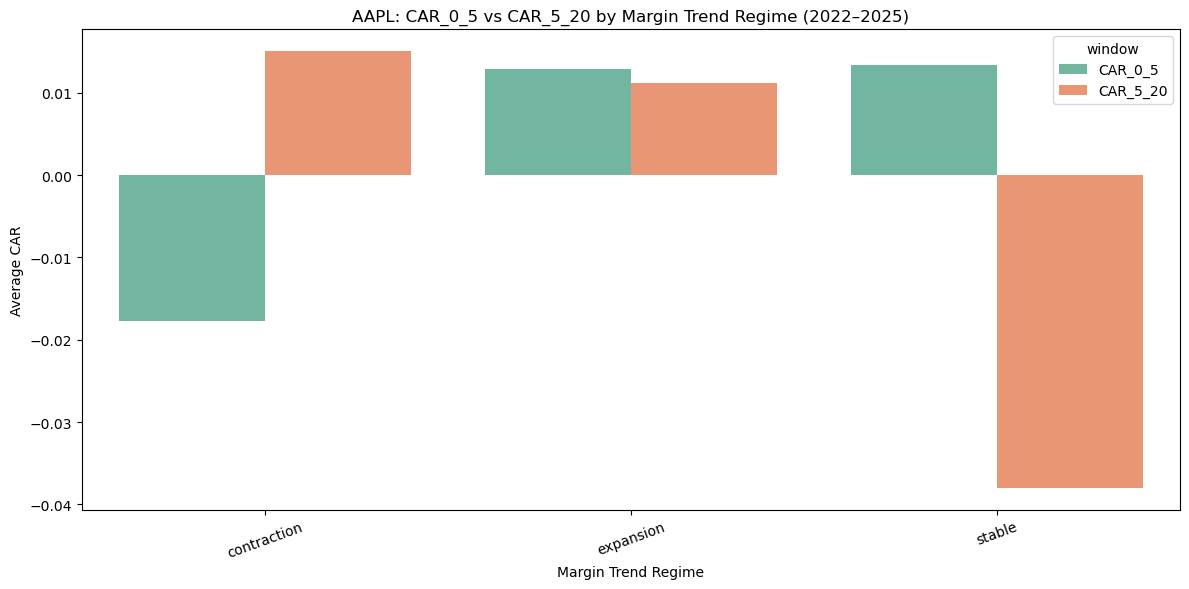

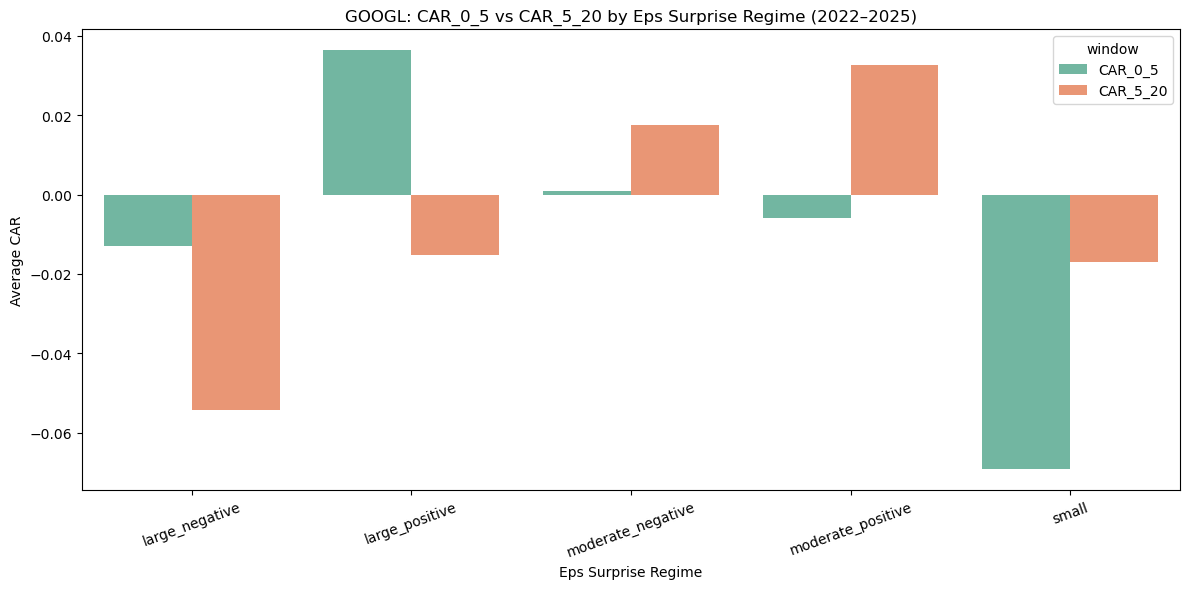

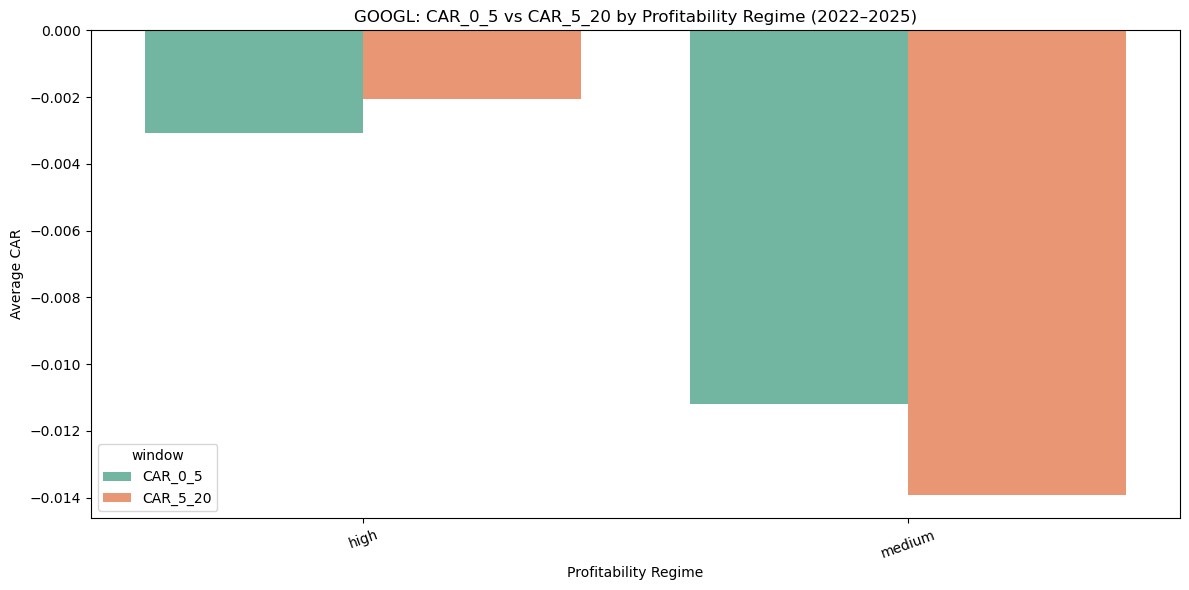

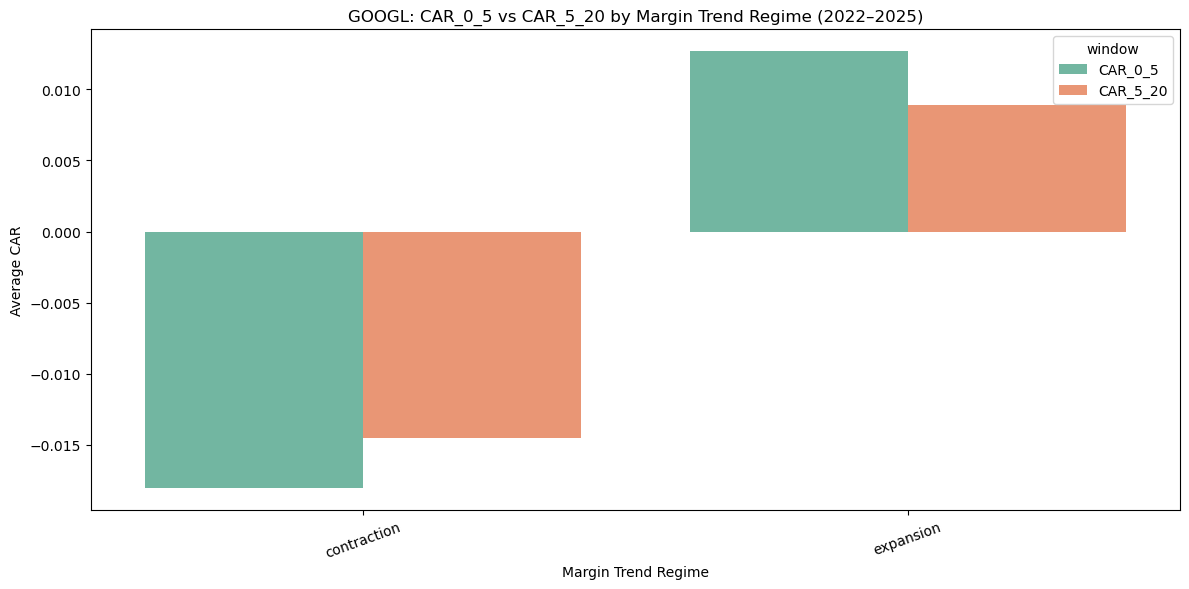

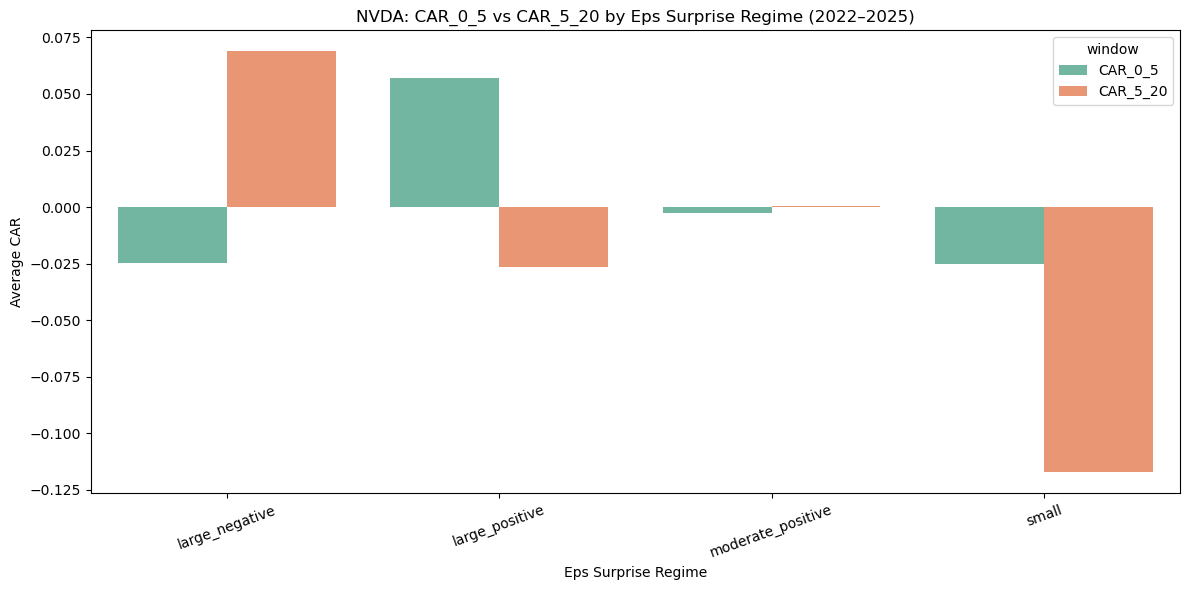

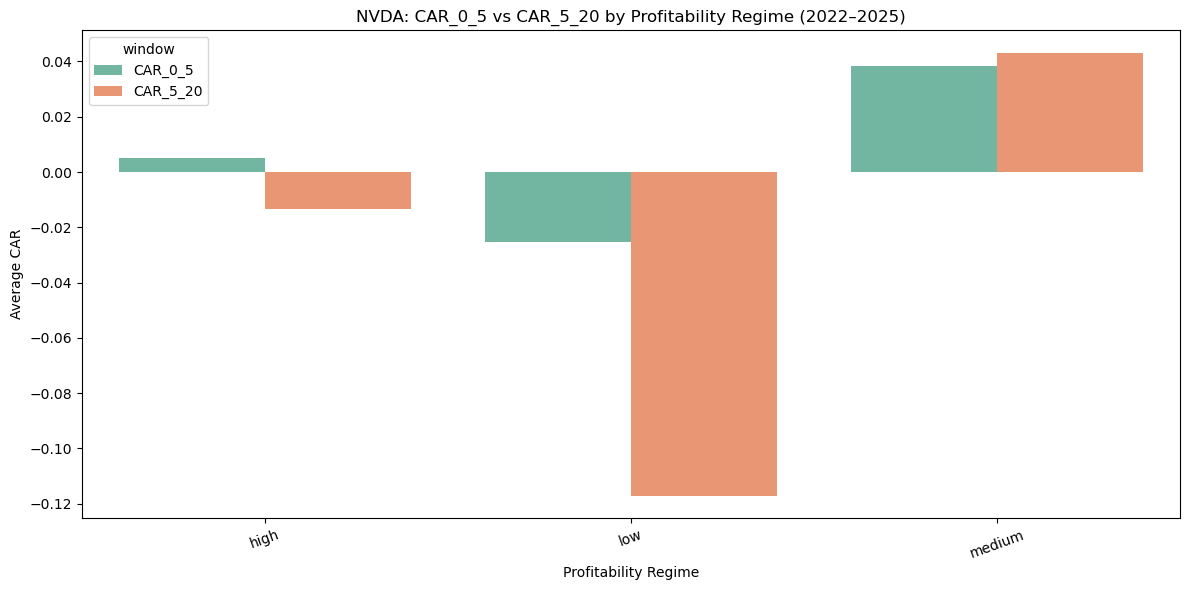

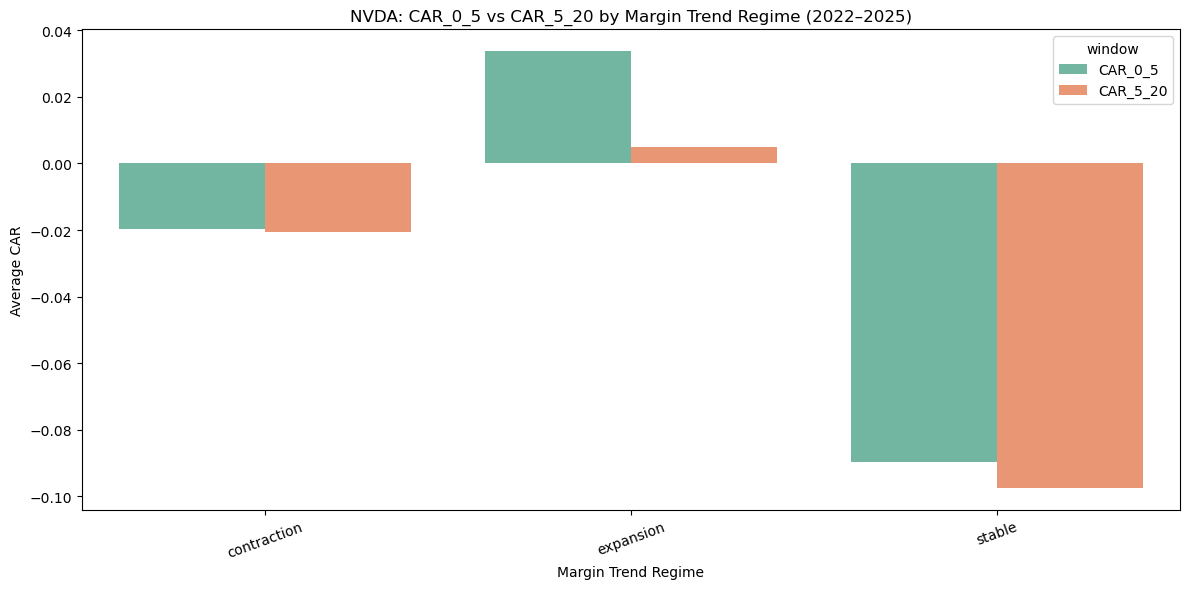

In [27]:
tickers = ["AAPL", "GOOGL", "NVDA"]
regimes = ["eps_surprise_regime", "profitability_regime", "margin_trend_regime"]

for t in tickers:
    for r in regimes:
        plot_bar_for_company(event_panel, t, r)